# **Data Ingestion and Pre-Processing**


 1) **Shapley values** come from game theory: they tell you how much each feature contributed to a prediction.

 For a model, SHAP gives
 attribution of
 the predictionto each feature. **This tells us which sensor likely caused this anomaly**

 For time series, we typically create lag features recent history so the
 model sees the temporal context.

SHAP will tell us which sensor and which
 lag mattered we can aggregate across lags to obtain a sensor tag level
explanation

In [ ]:
from google.colab import files
files.upload()

Saving 1.csv to 1.csv


{'1.csv': b'datetime;Accelerometer1RMS;Accelerometer2RMS;Current;Pressure;Temperature;Thermocouple;Voltage;Volume Flow RateRMS;anomaly;changepoint\r\n2020-03-09 10:34:33;0.0270797;0.039615;0.871339;0.054711;75.4955;25.8338;244.091;32.0;0.0;0.0\r\n2020-03-09 10:34:34;0.026995;0.0387587;1.30128;0.054711;75.5445;25.8408;224.17;32.0;0.0;0.0\r\n2020-03-09 10:34:35;0.0268071;0.0395207;1.2845;0.382638;75.6607;25.8227;234.157;32.9986;0.0;0.0\r\n2020-03-09 10:34:36;0.0268166;0.0386303;1.36495;0.054711;75.575;25.8262;229.902;32.9986;0.0;0.0\r\n2020-03-09 10:34:37;0.0263929;0.0387698;0.791839;0.054711;75.4351;25.8382;251.697;32.0015;0.0;0.0\r\n2020-03-09 10:34:38;0.0266461;0.0390294;0.750212;0.382638;75.5475;25.8164;246.404;32.0;0.0;0.0\r\n2020-03-09 10:34:40;0.0263552;0.0391757;1.26386;0.054711;75.562;25.8271;252.844;32.9986;0.0;0.0\r\n2020-03-09 10:34:41;0.0264336;0.0388913;0.670358;0.382638;75.5594;25.8319;232.287;32.0015;0.0;0.0\r\n2020-03-09 10:34:42;0.0261605;0.0383421;1.15674;0.054711;75.6

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt, seaborn as sns

RND = 42

In [ ]:
df = pd.read_csv("1.csv", sep=";", parse_dates=['datetime'])


In [ ]:
print(df.columns.tolist())
print(df.head())

['datetime', 'Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS', 'anomaly', 'changepoint']
             datetime  Accelerometer1RMS  ...  anomaly  changepoint
0 2020-03-09 10:34:33           0.027080  ...      0.0          0.0
1 2020-03-09 10:34:34           0.026995  ...      0.0          0.0
2 2020-03-09 10:34:35           0.026807  ...      0.0          0.0
3 2020-03-09 10:34:36           0.026817  ...      0.0          0.0
4 2020-03-09 10:34:37           0.026393  ...      0.0          0.0

[5 rows x 11 columns]


In [ ]:
import pandas as pd

df = pd.read_csv("1.csv", sep=";", parse_dates=['datetime'])

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))


if 'anomaly' in df.columns:
    print(df['anomaly'].value_counts())
else:
    print("No anomaly column found")


Shape: (1145, 11)
Columns: ['datetime', 'Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS', 'anomaly', 'changepoint']
             datetime  Accelerometer1RMS  ...  anomaly  changepoint
0 2020-03-09 10:34:33           0.027080  ...      0.0          0.0
1 2020-03-09 10:34:34           0.026995  ...      0.0          0.0
2 2020-03-09 10:34:35           0.026807  ...      0.0          0.0

[3 rows x 11 columns]
anomaly
0.0    743
1.0    402
Name: count, dtype: int64


# 2) **Feature Engineering via Lag Transformation**

lag features so the model can learn how sensor values evolve over time.
Because anomalies typically show gradual changes, lags capture these temporal signatures.

They allow the SHAP explanation to highlight which sensors, and at which prior timesteps, contributed to anomaly detection.


In [ ]:

sensors = [c for c in df.columns if (c.startswith('Accelerometer') or c.startswith('Current') or c.startswith('Pressure') or c.startswith('Temperature'))][:10]
n_lags = 8
for s in sensors:
    for k in range(1, n_lags+1):
        df[f"{s}_lag_{k}"] = df[s].shift(k)
df = df.dropna().reset_index(drop=True)
print("Lagged shape:", df.shape)

Lagged shape: (1137, 51)


# 3) **Train Test split**

This step transforms the multivariate time-series anomaly detection problem into a well-defined supervised classification task by:

Extracting temporal information through lag-feature construction

Selecting lag features as the fixed-dimensional input matrix

Using anomaly labels as the supervised target

Ensuring statistical consistency via stratified train-test split


contains event labels
contains temporal embeddings

This prepares the dataset for effective learning and SHAP-based interpretability.

In [ ]:
feat_cols = [c for c in df.columns if '_lag_' in c]
X = df[feat_cols]
y = df['anomaly'] if 'anomaly' in df.columns else None

if y is None:
    y = (df[sensors[0]] > df[sensors[0]].mean() + 3*df[sensors[0]].std()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RND)
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train label counts:", y_train.value_counts())

Train size: (909, 40) Test size: (228, 40)
Train label counts: anomaly
0.0    588
1.0    321
Name: count, dtype: int64


# 4) **Imbalance-Aware Model Training (XGBoost Classifier)**

 **Why XGBoost Is Ideal for SHAP-Based Fault Interpretation**

**TreeExplainer gives** exact Shapley values for all trees in an XGBoost ensemble
→ ensures mathematically sound, game-theoretic interpretability.

**Perfect for multivariate time-series:**

faults because SHAP can attribute importance to:

!) individual sensor features

2) lagged sensor histories

3) (temporal patterns)

sensor interactions captured by the boosted trees

**Captures nonlinear multivariate dependencies:**

XGBoost learns complex relationships between pressure, vibration, temperature, flow, etc., across multiple lags.

**Handles interaction terms naturally:**
Boosted decision trees automatically learn higher-order interactions (e.g., vibration spike + temperature rise pattern before a fault).

**Lag-wise contribution analysis**
SHAP identifies which historical window contributed (e.g., vibration at t−1 to t−4), enabling engineering insight into precursor behaviour.

In [ ]:
pos = y_train.sum()
scale = (len(y_train) - pos)/max(1, pos)

model = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.05,
                      use_label_encoder=False, eval_metric='auc', random_state=RND)
model.set_params(scale_pos_weight=scale)
model.fit(X_train, y_train)
print("Model trained with scale_pos_weight =", scale)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:16:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model trained with scale_pos_weight = 1.8317757009345794


# 5) **Model Performance Evaluation**

Model Evaluation

The model is evaluated using both:

**threshold-dependent metrics → precision, recall, F1**

**threshold-independent metrics → ROC–AUC**

**Traditional accuracy is misleading** in rare-event settings because the negative class dominates.
Precision/recall-based metrics reflect how well the model identifies the minority (fault) class.

**Hard predictions** (0/1 decisions) reveal direct classification performance on anomalies
essential for understanding how many fault samples are actually detected.

**Probability outputs** enable ROC–AUC calculation, which measures ranking ability independent of any threshold.

**Evaluation validates whether the model has learned meaningful temporal patterns** embedded in the lagged sensor features and multivariate interactions.

Reliable prediction performance is a prerequisite for SHAP analysis.


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred, zero_division=0))
try:
    print("ROC AUC:", roc_auc_score(y_test, proba))
except:
    print("ROC AUC not available (maybe one class in test)")

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       147
         1.0       0.70      0.80      0.75        81

    accuracy                           0.81       228
   macro avg       0.79      0.81      0.80       228
weighted avg       0.82      0.81      0.81       228

ROC AUC: 0.8826740572772319


# 6) **Feature Attribution Using SHAP Summary Statistics**

SHAP values can be computed exactly and efficiently using tree-path decomposition  avoiding the exponential cost of brute-force Shapley computation.

**Why SHAP is essential in rare-event analysis:**

Lag features encode temporal behavior. SHAP decomposes the anomaly prediction into contributions from:

**Why aggregation is required**

Lag features expand each sensor into multiple derivatives

**This bar plot visually communicates:**
Global anomaly driving sensors

**Local Accuracy:** explanations sum to prediction

**Consistency**: if a model relies more on a feature, its SHAP value does not decrease

**Missingness:** irrelevant features get zero contribution

Plot quantifies how much each sensors historical behavior (lags) contributed to the models anomaly predictions.
Rather than analyzing individual lag features, SHAP values are grouped by sensor, giving a clear tag level view.


The model identifies Temperature as the dominant anomaly driver, supported by meaningful contributions from vibration sensors and electrical current. Temperature likely exhibits the clearest temporal deviation patterns preceding anomalies. Vibration (Accelerometer2RMS, Accelerometer1RMS) and Current reflect secondary mechanical/electrical fault signatures. Pressure contributes minimally, indicating it is not associated with the anomalies in this dataset.

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


Top sensors contributing: Temperature          0.319122
Accelerometer2RMS    0.113608
Accelerometer1RMS    0.065255
Current              0.062570
Pressure             0.006776
dtype: float32


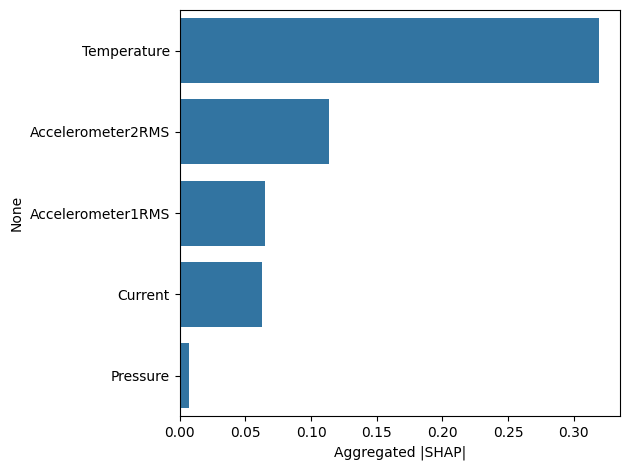

In [ ]:
sensor_shap = {}
for s in sensors:
    lag_feats = [c for c in X_test.columns if c.startswith(s + '_lag_')]
    if not lag_feats: continue
    idxs = [X_test.columns.get_loc(c) for c in lag_feats]
    sensor_shap[s] = np.mean(np.abs(shap_values[:, idxs])).sum()

import pandas as pd
sensor_rank = pd.Series(sensor_shap).sort_values(ascending=False)
print("Top sensors contributing:", sensor_rank.head(6))
sns.barplot(x=sensor_rank.values, y=sensor_rank.index)
plt.xlabel('Aggregated |SHAP|')
plt.tight_layout()
plt.show()

6) **A SHAP waterfall plot**

A SHAP waterfall plot was generated to provide a local explanation for a single anomaly instance.
The plot decomposes the model’s prediction into additive Shapley values that quantify the contribution of each lagged sensor feature to the deviation from the baseline prediction.
Positive contributions indicate temporal sensor patterns that increased the probability of anomaly, while negative contributions reduced it.
This method enables precise root-cause analysis by identifying the specific sensor-lag combinations that were decisive for the anomaly at that timestamp.
Unlike force plots, waterfall plots are fully compatible with high-dimensional lag features and render reliably in static environments, making them suitable for engineering diagnostics and reporting.

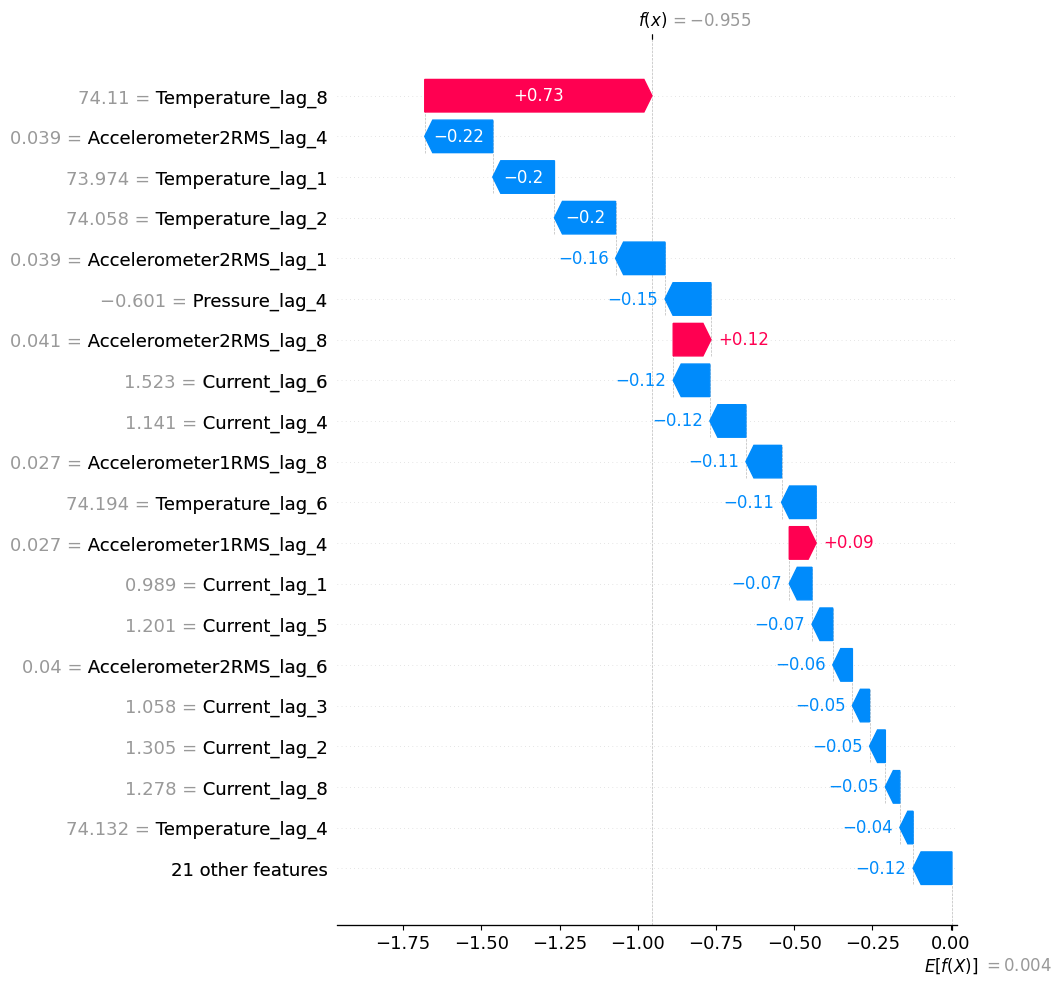

In [ ]:
anomalous_indices = y_test[y_test == 1.0].index
if not anomalous_indices.empty:
    idx = anomalous_indices[0]
else:
    idx = X_test.index[0]
    print("No anomalous events in test set, plotting a random instance.")

shap_explanation = shap.Explanation(
    values=shap_values[X_test.index.get_loc(idx)],
    base_values=explainer.expected_value,
    data=X_test.loc[idx],
    feature_names=X_test.columns.tolist()
)

shap.plots.waterfall(shap_explanation, max_display=20)